In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [2]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [3]:
def potential(x,k,l,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=-10/x-10*torch.sin(torch.pi*x/24)/x+x/20
    return poten

In [4]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [5]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:8" if torch.cuda.is_available() else "cpu")

La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0
# 控制势函数的大小
scale=10

en_num=30
extend_num=10
epoch=200000
lr=0.01


In [6]:
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,b_lap,l,scale)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

real_en=eigenvalues[:en_num].detach()
print('initial eigenvalues check:')
print(eigenvalues[:en_num+extend_num])

initial eigenvalues check:
tensor([-5.0544e+01, -1.3729e+01, -6.7799e+00, -4.2884e+00, -3.0701e+00,
        -2.3361e+00, -1.8200e+00, -1.4152e+00, -1.0747e+00, -7.7522e-01,
        -5.0460e-01, -2.5575e-01, -2.4356e-02,  1.9234e-01,  3.9624e-01,
         5.8844e-01,  7.6994e-01,  9.4114e-01,  1.1025e+00,  1.2546e+00,
         1.3972e+00,  1.5288e+00,  1.6511e+00,  1.7639e+00,  1.8660e+00,
         1.9576e+00,  2.0391e+00,  2.1120e+00,  2.1789e+00,  2.2425e+00,
         2.3048e+00,  2.3668e+00,  2.4289e+00,  2.4915e+00,  2.5546e+00,
         2.6182e+00,  2.6822e+00,  2.7468e+00,  2.8117e+00,  2.8770e+00],
       device='cuda:8')


In [7]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=80,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    
    output=eigenvalues[:en_num]
    loss=loss_fn(output,real_en)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        print('\nepoch:',i)
        print(eigenvalues[:en_num])
        print(real_en)
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:3.5677685737609863,time:0.23194432258605957,lr:0.01

epoch: 0
tensor([-0.1102, -0.0930, -0.0810, -0.0687, -0.0588, -0.0498, -0.0482, -0.0412,
        -0.0340, -0.0259, -0.0158, -0.0052,  0.0068,  0.0198,  0.0341,  0.0496,
         0.0653,  0.0825,  0.1008,  0.1198,  0.1398,  0.1610,  0.1832,  0.2065,
         0.2306,  0.2556,  0.2816,  0.3087,  0.3367,  0.3658], device='cuda:8',
       grad_fn=<SliceBackward0>)
tensor([-5.0544e+01, -1.3729e+01, -6.7799e+00, -4.2884e+00, -3.0701e+00,
        -2.3361e+00, -1.8200e+00, -1.4152e+00, -1.0747e+00, -7.7522e-01,
        -5.0460e-01, -2.5575e-01, -2.4356e-02,  1.9234e-01,  3.9624e-01,
         5.8844e-01,  7.6994e-01,  9.4114e-01,  1.1025e+00,  1.2546e+00,
         1.3972e+00,  1.5288e+00,  1.6511e+00,  1.7639e+00,  1.8660e+00,
         1.9576e+00,  2.0391e+00,  2.1120e+00,  2.1789e+00,  2.2425e+00],
       device='cuda:8')
epoch:10,loss:2.509211301803589,time:1.2553534507751465,lr:0.01

epoch: 10
tensor([-4.0509, -3.5847, -3.1498,

In [8]:
# -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
#         -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02
# -1.2695e-01, -9.2922e-02, -5.8262e-02, -2.2549e-02,  1.4835e-02,
#          5.1943e-02,  9.0080e-02,  1.2834e-01,  1.6763e-01,  2.0718e-01

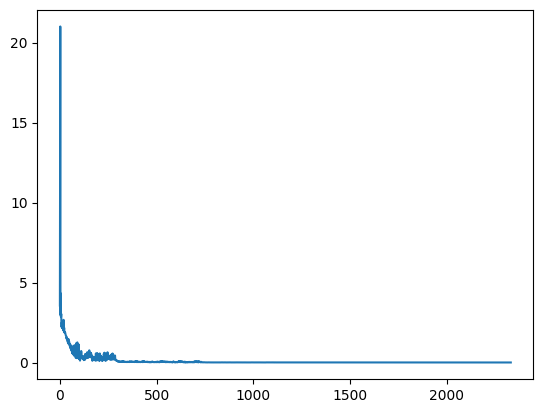

In [9]:
plt.plot(loss_list)
plt.show()

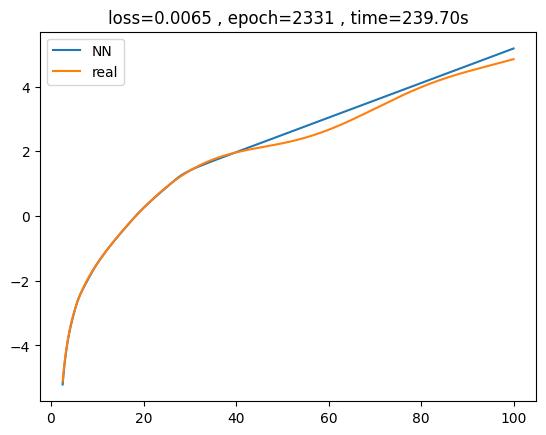

In [10]:
La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[100:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,l,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


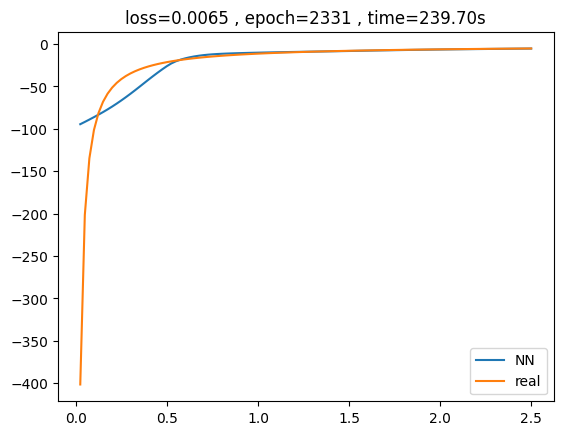

In [11]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:100]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,l,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

In [12]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]

error=output-real_en
rela_error=error/real_en
print('final error:',error)
print('relative error:',rela_error)

final error: tensor([-7.2479e-05,  2.2888e-05, -8.4400e-05, -7.9155e-05, -2.1410e-03,
         7.9837e-03, -5.0859e-03, -8.8692e-05,  4.8041e-04,  1.7881e-06,
        -1.1539e-03, -1.2251e-03, -7.8026e-05,  1.7322e-03,  1.1480e-03,
        -1.0186e-03, -2.6628e-03, -2.6987e-03, -6.6280e-05,  4.1684e-03,
         5.5559e-03, -6.8069e-05, -7.6408e-03, -1.4029e-02, -1.5538e-02,
        -1.1308e-02, -4.7874e-04,  1.5912e-02,  3.5673e-02,  5.6520e-02],
       device='cuda:8', grad_fn=<SubBackward0>)
relative error: tensor([ 1.4340e-06, -1.6671e-06,  1.2449e-05,  1.8458e-05,  6.9738e-04,
        -3.4175e-03,  2.7945e-03,  6.2669e-05, -4.4701e-04, -2.3066e-06,
         2.2867e-03,  4.7904e-03,  3.2035e-03,  9.0055e-03,  2.8972e-03,
        -1.7310e-03, -3.4584e-03, -2.8675e-03, -6.0117e-05,  3.3226e-03,
         3.9765e-03, -4.4525e-05, -4.6277e-03, -7.9533e-03, -8.3272e-03,
        -5.7768e-03, -2.3478e-04,  7.5340e-03,  1.6372e-02,  2.5204e-02],
       device='cuda:8', grad_fn=<DivBackward0

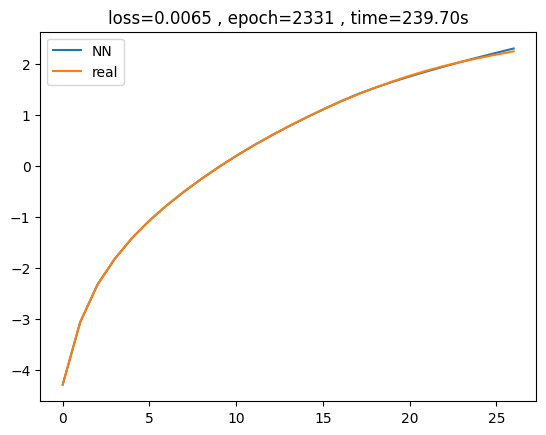

In [16]:
plt.plot(output[3:].detach().cpu().numpy(),label='NN')
plt.plot(real_en[3:].detach().cpu().numpy(),label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

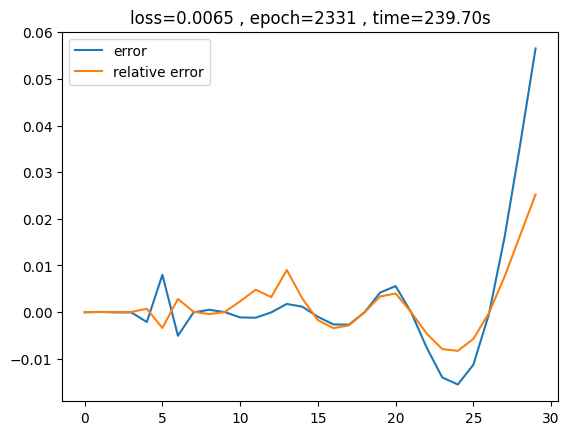

In [14]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()